<a href="https://colab.research.google.com/github/darshnkd/cybersecurity-threat-classification/blob/main/cyber_threat_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Run the Code

## Run on Google Colab
1. **Open Google Colab**
- Go to [Google Colab] (https://colab.research.google.com/)
- Click on **"Upload Notebook"**
- Select 'Cybersecurity_Threat_classification.ipynb'

2. **Connect to GPU (optional for MLP Training)**
- In Colab, go to **Runtime** -> **Change runtime type**
- Select **GPU** and click **Save**

3. **Mount Google Drive & Load Dataset**
- Run the first cell in the  notebook to mount your Google Drive:
  ```python
  from google.colab import drive
  drive.mount('/content/drive')
  - Upload the dataset ('CICIDS2017') to your drive and update the dataset path in the notebook accordingly.
  - To upload the dataset on your drive first you can download the dataset from kaggle or you can use kaggle API.```

4. ** Install required libraries** (if not alredy installed)
- The notebook contain cell for installing dependencies. Run:
  ``` python
  !pip install pandas numpy scikit-learn matplotlib seaborn torch imbalanced-learn.```

5. **Run the Notebook**
- Execute each cell sequentially by clicking the **shift+enter**
- The notebook will load the dataset,preprocess it, train the model, and display evaluation results.


## **CyberSecurity Threat Classification**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/

 Classroom		 IMG20250204120505.jpg	 kaggle.json
'Colab Notebooks'	 IMG20250204120506.jpg	'Untitled document.gdoc'
 IMG20250204120446.jpg	 IMG20250204120508.jpg


In [ ]:
# Create Kaggle directory and copy API key
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

# Set proper permissions
!chmod 600 ~/.kaggle/kaggle.json

### **1. Download the Dataset CICIDS2017**

In [ ]:
!kaggle datasets download -d chethuhn/network-intrusion-dataset

Dataset URL: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset
License(s): CC0-1.0
network-intrusion-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zipfile.ZipFile("network-intrusion-dataset.zip", "r").extractall("dataset")

In [ ]:
!ls dataset/

Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv


### **2. Import  Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(43)

### **3. Load the Dataset**

In [ ]:
# Create function to load data
def load_data(filepaths):
  "Load CIS IDC 2017 Dataset"

  all_dfs=[]
  for filepath in filepaths:
    print(f"Loading Dataset...")
    df=pd.read_csv(filepath)
    print(f"Loaded {filepath} : Shape  {df.shape}")
    all_dfs.append(df)

  # Concatenate all dataframe
  final_df = pd.concat(all_dfs, ignore_index=True)
  print(f"\nFinal Dataset Shape :{final_df.shape} ")

  # Display the preview of dataset
  print("\nPreview of Dataset")
  print(final_df.head())

  # List all the columns
  print("\nAll columns in dataset:")
  print(final_df.columns)

  return final_df

In [ ]:
filepaths = ['dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv','dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
             'dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv','dataset/Monday-WorkingHours.pcap_ISCX.csv',
             'dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv','dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
             'dataset/Tuesday-WorkingHours.pcap_ISCX.csv','dataset/Wednesday-workingHours.pcap_ISCX.csv']

final_df = load_data(filepaths)

Loading Dataset...
Loaded dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv : Shape  (225745, 79)
Loading Dataset...
Loaded dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv : Shape  (286467, 79)
Loading Dataset...
Loaded dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv : Shape  (191033, 79)
Loading Dataset...
Loaded dataset/Monday-WorkingHours.pcap_ISCX.csv : Shape  (529918, 79)
Loading Dataset...
Loaded dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv : Shape  (288602, 79)
Loading Dataset...
Loaded dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv : Shape  (170366, 79)
Loading Dataset...
Loaded dataset/Tuesday-WorkingHours.pcap_ISCX.csv : Shape  (445909, 79)
Loading Dataset...
Loaded dataset/Wednesday-workingHours.pcap_ISCX.csv : Shape  (692703, 79)

Final Dataset Shape :(2830743, 79) 

Preview of Dataset
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1         

In [ ]:
# Remove the extra spaces from the columns names
final_df.columns = final_df.columns.str.strip()

### **4. Check the Unique Labels and Visualize the Target Distribution**

In [ ]:
# Check unique values in label column
print(final_df['Label'].unique())

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


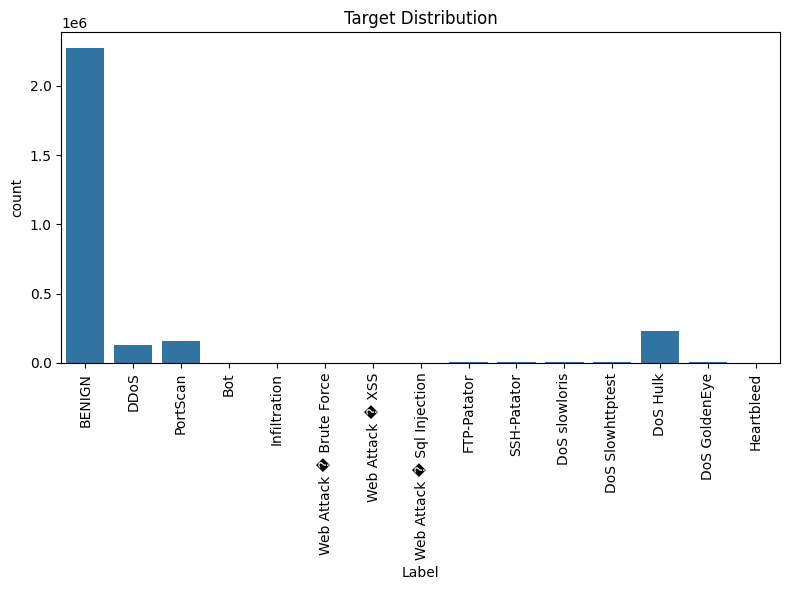

In [ ]:
# Visualize the target distributions
plt.figure(figsize=(8,6))
sns.countplot(x='Label',data=final_df)
plt.title('Target Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

### **5. Count the Samples in Each Class**

In [ ]:

# Show the target distribution
print(final_df['Label'].value_counts())

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


### **6. Data Preprocessing**

In [ ]:
# Make the function Preprocess the data
def preprocess_data(df):
  "Clean and Preprocess tha Data"
  print("\nPreprocessing the Data...")

  # Check memory usages
  print(f"\nMemory usages before optimization : {df.memory_usage(deep=True).sum()/1024**2:.2f}MB")

  # Downcaste numericals columns to save memory
  df = df.copy()
  for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col],downcast='integer')

  for col in df.select_dtypes(include=['float64']).columns:
    df[col] = pd.to_numeric(df[col],downcast='float')

  # Check memory usages
  print(f"\nMemory usages after optimization :{df.memory_usage(deep=True).sum()/1024**2:.2f}MB")

  # Remove or replace the infinity values
  for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].replace([np.inf,-np.inf],np.nan)

  # Check for missing values
  missing_values = df.isnull().sum()
  print(f"\nMissing values: {missing_values[missing_values > 0]}")

  # Visualize the missing values
  if missing_values.sum() > 0:
    sample_df = df.sample(n=50000,random_state=42)
    plt.figure(figsize=(8,6))
    sns.heatmap(sample_df.isnull(),cbar=False,yticklabels=False,cmap='viridis')
    plt.title('Missing Values Heatmap(Sampled Data)')
    plt.tight_layout()
    plt.show();

  # Drops rows with missing values
  df_clean = df.dropna().copy()
  print(f"Dataset shape after dropping missing values: {df_clean.shape}")

  # Encode Categorial features
  le = LabelEncoder()

  # Indentify the categorical columns (excluding the target variable)
  cat_cols = [col for col in df_clean.columns if df_clean[col].dtype == 'object' and col != 'Label']
  print(f"\nCategorial columns : {cat_cols}")

  # Apply label encoding
  for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

  # Encode the target variables
  target_encoder = LabelEncoder()
  df_clean['Label'] = target_encoder.fit_transform(df_clean['Label'])

  # Store the target encoding mapping for later reference
  target_mapping = dict(zip(target_encoder.classes_,range(len(target_encoder.classes_))))
  print(f"\nTarget variable encoding:")
  for Original, encoded in target_mapping.items():
    print(f"{Original}->{encoded}")

  return df_clean , target_mapping , target_encoder


Preprocessing the Data...

Memory usages before optimization : 1855.53MB

Memory usages after optimization :1013.25MB

Missing values: Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64


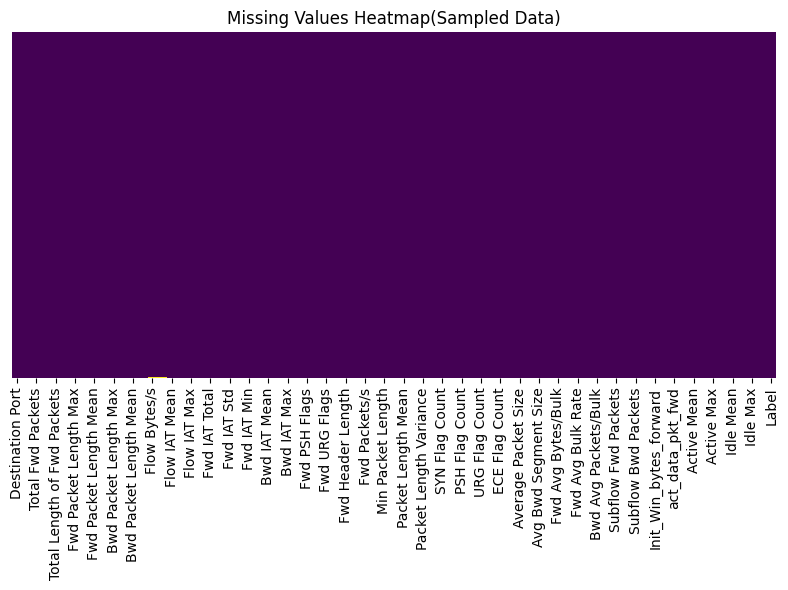

Dataset shape after dropping missing values: (2827876, 79)

Categorial columns : []

Target variable encoding:
BENIGN->0
Bot->1
DDoS->2
DoS GoldenEye->3
DoS Hulk->4
DoS Slowhttptest->5
DoS slowloris->6
FTP-Patator->7
Heartbleed->8
Infiltration->9
PortScan->10
SSH-Patator->11
Web Attack � Brute Force->12
Web Attack � Sql Injection->13
Web Attack � XSS->14


In [ ]:
cleaned_df, target_mapping, target_encoder = preprocess_data(final_df)

### **7. Feature Selection**

In [ ]:
def select_features(df,target_col,k=15):
  "Select the top k most revelent features using SelectKBest"

  # Seperate the feature and target
  X = df.drop(columns=[target_col])
  y = df[target_col]

  # Apply SelectKBest with f_classif (ANOVA F-value)
  selector = SelectKBest(f_classif,k=k)
  X_new = selector.fit_transform(X,y)

  # Get the selected feature names
  selected_col = X.columns[selector.get_support()]
  print(f"\nTop {k} selected features:")
  for col in selected_col:
    print(f" - {col}")

  # Feature importance score
  importance_score  = selector.scores_
  feature_importance = pd.DataFrame({
      'Feature' : X.columns,
      'Importance Score' : importance_score
  }).sort_values(by='Importance Score',ascending=False)

  # Create new dataframe with only selected features
  selected_df = pd.DataFrame(X_new,columns=selected_col)
  selected_df[target_col] = y.values

  return selected_df, selected_col, feature_importance

In [ ]:
selected_df, selected_col, features_importance = select_features(cleaned_df, 'Label',k=15 )


Top 15 selected features:
 - Bwd Packet Length Max
 - Bwd Packet Length Mean
 - Bwd Packet Length Std
 - Flow IAT Max
 - Fwd IAT Std
 - Fwd IAT Max
 - Max Packet Length
 - Packet Length Mean
 - Packet Length Std
 - Packet Length Variance
 - Average Packet Size
 - Avg Bwd Segment Size
 - Idle Mean
 - Idle Max
 - Idle Min


### **8. Data Splitting and Scaling**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

def prepare_data_for_training(df, target_col, test_size=0.2):
    """Split Data, Apply Hybrid Sampling (SMOTE + Undersampling), and Scale Features"""
    print("\nPreparing data for training...")

    # Split into features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    print(f"Training set shape before Sampling: {X_train.shape}")
    print(y_train.value_counts())

    # Define SMOTE sampling strategy: Increase minority classes by 50%
    majority_class_count = y_train.value_counts().max()
    smote_strategy = {
        cls: min(int(count * 1.5), majority_class_count)  # Increase by 50%
        for cls, count in y_train.value_counts().items()
        if count < majority_class_count  # Only oversample minority classes
    }

    # Apply SMOTE to oversample minority classes
    smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Define undersampling strategy: Reduce the majority class to 40% of its original size
    rus_strategy = {cls: int(count * 0.4) for cls, count in y_train_smote.value_counts().items() if count > majority_class_count * 0.5}

    # Apply undersampling to balance the dataset
    rus = RandomUnderSampler(sampling_strategy=rus_strategy, random_state=42)
    X_train_final, y_train_final = rus.fit_resample(X_train_smote, y_train_smote)

    print(f"\nTraining set shape after Hybrid Sampling: {X_train_final.shape}")
    print(y_train_final.value_counts())

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_final)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, "scaler.pkl")
    print("Scaler saved successfully as scaler.pkl")



    return X_train_scaled, X_test_scaled, y_train_final.values, y_test.values, scaler

In [ ]:
X_train_scaled, X_test_scaled, y_train_resampled, y_test,_ = prepare_data_for_training(selected_df,'Label')


Preparing data for training...
Training set shape before Sampling: (2262300, 15)
Label
0     1817055
4      184099
10     127043
2      102420
3        8234
7        6348
11       4717
6        4637
5        4399
1        1565
12       1206
14        522
9          29
13         17
8           9
Name: count, dtype: int64

Training set shape after Hybrid Sampling: (1394685, 15)
Label
0     726822
4     276148
10    190564
2     153630
3      12351
7       9522
11      7075
6       6955
5       6598
1       2347
12      1809
14       783
9         43
13        25
8         13
Name: count, dtype: int64
Scaler saved successfully as scaler.pkl


### **9. Model 1 (Random Forest)**

In [ ]:
# Random Forest Model
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100):
  "Train Random Forest Model and Evaluate the Performance"

  print(f"Training Random Forest Model...")

  # Create and train the model
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
  model.fit(X_train, y_train)

  # Make predictions
  y_preds = model.predict(X_test)

  # Calculates the metrics
  accuracy = accuracy_score(y_test,y_preds)
  precision = precision_score(y_test,y_preds,average='weighted')
  recall = recall_score(y_test,y_preds,average='weighted')
  f1 = f1_score(y_test,y_preds,average='weighted')

  print(f"Model's Performance:")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  # Feature Importance
  feature_importances = model.feature_importances_

  return model, y_preds, {
      'accuracy' : accuracy,
      'precision' : precision,
      'recall' : recall,
      'f1' : f1
  }, feature_importances

### **10. Evaluation Metrics**

In [ ]:
model, y_preds, metrics, features_importance = train_random_forest(X_train_scaled,y_train_resampled,X_test_scaled,y_test)

Training Random Forest Model...
Model's Performance:
Accuracy: 0.9819
Precision: 0.9838
Recall: 0.9819
F1 Score: 0.9822


In [ ]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    454265
           1       0.65      0.60      0.62       391
           2       1.00      1.00      1.00     25605
           3       0.97      0.99      0.98      2059
           4       0.85      0.99      0.91     46025
           5       0.96      0.99      0.97      1100
           6       0.99      1.00      0.99      1159
           7       0.94      1.00      0.97      1587
           8       1.00      1.00      1.00         2
           9       0.80      0.57      0.67         7
          10       0.99      1.00      1.00     31761
          11       0.99      0.53      0.69      1180
          12       0.71      0.66      0.69       301
          13       1.00      0.25      0.40         4
          14       0.40      0.33      0.36       130

    accuracy                           0.98    565576
   macro avg       0.88      0.79      0.82    565576
weighted avg       0.98   

In [ ]:
import joblib

# Save the trained model
joblib.dump(model, "random_forest_model.pkl")

# Download the model
from google.colab import files
files.download("random_forest_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the model
loaded_rf = joblib.load("random_forest_model.pkl")

# Use the loaded model for predictions
y_preds_rf = loaded_rf.predict(X_test_scaled)
print(classification_report(y_test,y_preds_rf))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    454265
           1       0.65      0.60      0.62       391
           2       1.00      1.00      1.00     25605
           3       0.97      0.99      0.98      2059
           4       0.85      0.99      0.91     46025
           5       0.96      0.99      0.97      1100
           6       0.99      1.00      0.99      1159
           7       0.94      1.00      0.97      1587
           8       1.00      1.00      1.00         2
           9       0.80      0.57      0.67         7
          10       0.99      1.00      1.00     31761
          11       0.99      0.53      0.69      1180
          12       0.71      0.66      0.69       301
          13       1.00      0.25      0.40         4
          14       0.40      0.33      0.36       130

    accuracy                           0.98    565576
   macro avg       0.88      0.79      0.82    565576
weighted avg       0.98   

### **11. XGBoost Model**

In [ ]:
# Initialize XGBoost classifier

import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=len(np.unique(y_train_resampled)),  # Number of classes
    eval_metric="mlogloss",  # Loss function
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Train the model
xgb_model.fit(X_train_scaled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=15, num_parallel_tree=None, ...)

In [ ]:
# Make predictions
y_preds_xgb = xgb_model.predict(X_test_scaled)

# Print classification report
print(classification_report(y_test, y_preds_xgb))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    454265
           1       0.57      0.59      0.58       391
           2       1.00      1.00      1.00     25605
           3       0.98      0.97      0.98      2059
           4       0.84      0.99      0.91     46025
           5       0.94      0.99      0.96      1100
           6       0.99      0.99      0.99      1159
           7       0.94      1.00      0.97      1587
           8       1.00      1.00      1.00         2
           9       1.00      0.43      0.60         7
          10       0.99      1.00      0.99     31761
          11       1.00      0.52      0.68      1180
          12       0.97      0.13      0.22       301
          13       0.00      0.00      0.00         4
          14       0.33      0.02      0.03       130

    accuracy                           0.98    565576
   macro avg       0.84      0.71      0.73    565576
weighted avg       0.98   

### **12. Visualization**

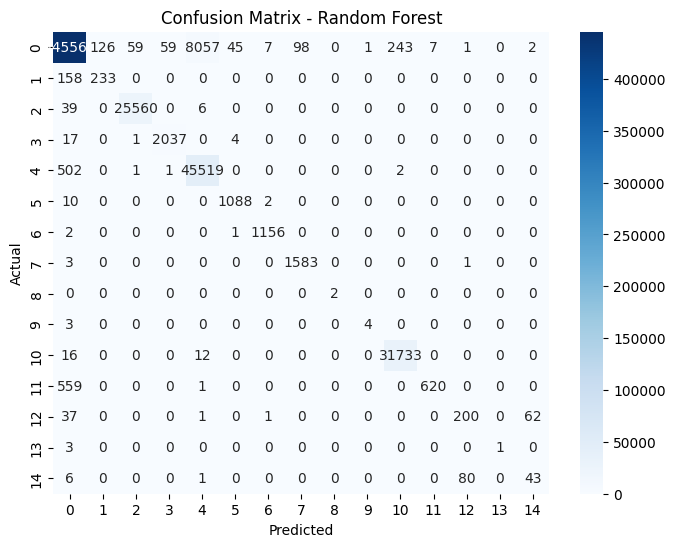

In [ ]:
# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_preds)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

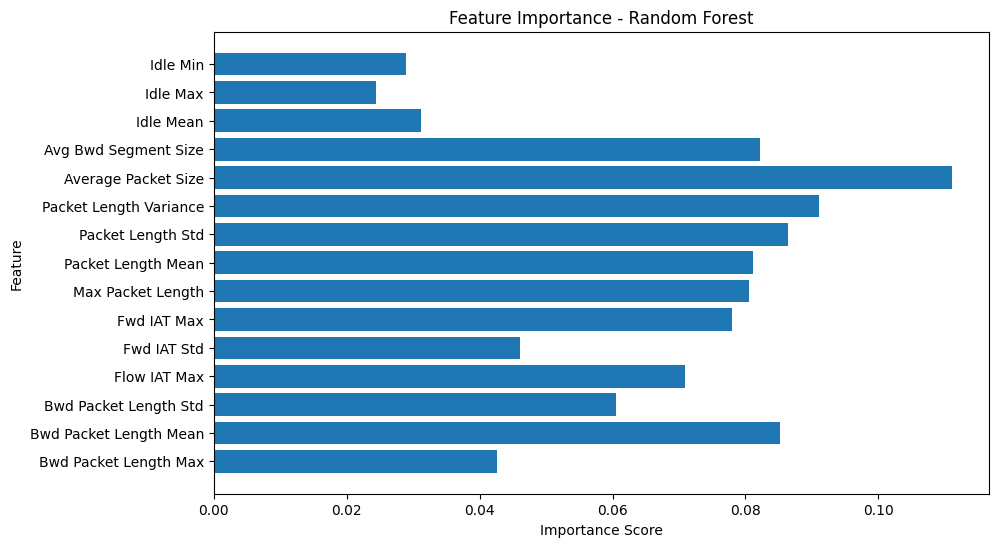

In [ ]:
# Get feature importance scores
importances = features_importance
feature_names = selected_col

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.show()

## **Let's Build the Neural Network**

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### **1. Set Up Device Agnostic Code**

In [ ]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### **2. Create a PyTorch Dataset**

In [ ]:
# Let's create the PyTorch Dataset for Neural Network
class CyberThreatDataset(Dataset):
  def __init__(self,features,labels):
    self.features = torch.FloatTensor(features)
    self.labels = torch.LongTensor(labels)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    return self.features[idx], self.labels[idx]

### **3. Define MLP (Multi-layer Perceptron) Model**

In [ ]:
# MLP Architecture
class CyberThreatNN(nn.Module):
  def __init__(self,input_size,num_classes):
    super(CyberThreatNN, self).__init__()

    # Create the dynamic layers with the normalization and dropout
    self.network = nn.Sequential(
        nn.Linear(input_size, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(64, num_classes)
    )

  def forward(self,x):
    return self.network(x)

### **4. Create DataLoaders and Initilize the Loss_fn, Optimizer and Model**

In [ ]:
# Convert our data to PyTorch Dataset
train_dataset = CyberThreatDataset(X_train_scaled, y_train_resampled)
test_dataset = CyberThreatDataset(X_test_scaled, y_test)

# Create DataLoaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle = True)
test_loader = DataLoader(test_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

# Initilize model, loss, optimizer
mlp_model = CyberThreatNN(input_size=X_train_scaled.shape[1],num_classes=len(np.unique(y_train_resampled))).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp_model.parameters(),lr = 0.0001, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=3,verbose=True)

### **5. Train Function (training loop)**

In [ ]:
# Training function
def train_nn(model, train_loader, test_loader, loss_fn, optimizer,device,epochs=10):
  # Tracking metrics
  train_losses, test_losses = [],[]
  train_accs, test_accs = [],[]

  # Training Loop
  for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch+1}/{epochs}:\n-------")

    # Training phase
    model.train()
    train_loss, train_correct, train_total = 0.0,0,0

    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _,predicted = torch.max(outputs.data,1)
      train_total += labels.size(0)
      train_correct += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    test_loss, test_correct, test_total = 0.0,0,0
    with torch.no_grad():
      for inputs,labels in test_loader:
        inputs, labels = inputs.to(device),labels.to(device)
        test_outputs = model(inputs)
        loss = loss_fn(test_outputs,labels)
        test_loss += loss.item()
        _,predicted = torch.max(test_outputs.data,1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    # Calculate the metrics
    train_loss = train_loss / len(train_loader)
    test_loss = test_loss / len(test_loader)
    train_acc = train_correct / train_total
    test_acc = test_correct / test_total

    # Store the metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Adjust learning rate
    scheduler.step(test_loss)

    # print progress
    if epochs % 5 ==0: # for 10 epochs we dont need so I put epochs insted of epoch
      print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

  # Plotting training cureves
  plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.plot(train_losses,label='Train Loss')
  plt.plot(test_losses,label='Test Loss')
  plt.title('Loss Curve')
  plt.xlabel('Epochs')
  plt.plot('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(train_accs,label='Train Acc')
  plt.plot(test_accs,label='Test Acc')
  plt.title('Accuracy Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

  return model, train_losses, test_losses, train_accs, test_accs

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1/10:
-------
Train Loss: 0.7442 | Train Acc: 0.73 | Test Loss: 0.3965 | Test Acc: 0.79
Epoch : 2/10:
-------
Train Loss: 0.5561 | Train Acc: 0.77 | Test Loss: 0.4003 | Test Acc: 0.79
Epoch : 3/10:
-------
Train Loss: 0.5236 | Train Acc: 0.78 | Test Loss: 0.3481 | Test Acc: 0.83
Epoch : 4/10:
-------
Train Loss: 0.5015 | Train Acc: 0.79 | Test Loss: 0.3220 | Test Acc: 0.84
Epoch : 5/10:
-------
Train Loss: 0.4827 | Train Acc: 0.80 | Test Loss: 0.2832 | Test Acc: 0.86
Epoch : 6/10:
-------
Train Loss: 0.4652 | Train Acc: 0.81 | Test Loss: 0.2981 | Test Acc: 0.84
Epoch : 7/10:
-------
Train Loss: 0.4498 | Train Acc: 0.82 | Test Loss: 0.2526 | Test Acc: 0.87
Epoch : 8/10:
-------
Train Loss: 0.4350 | Train Acc: 0.82 | Test Loss: 0.3160 | Test Acc: 0.81
Epoch : 9/10:
-------
Train Loss: 0.4212 | Train Acc: 0.83 | Test Loss: 0.2335 | Test Acc: 0.94
Epoch : 10/10:
-------
Train Loss: 0.4103 | Train Acc: 0.83 | Test Loss: 0.2734 | Test Acc: 0.84


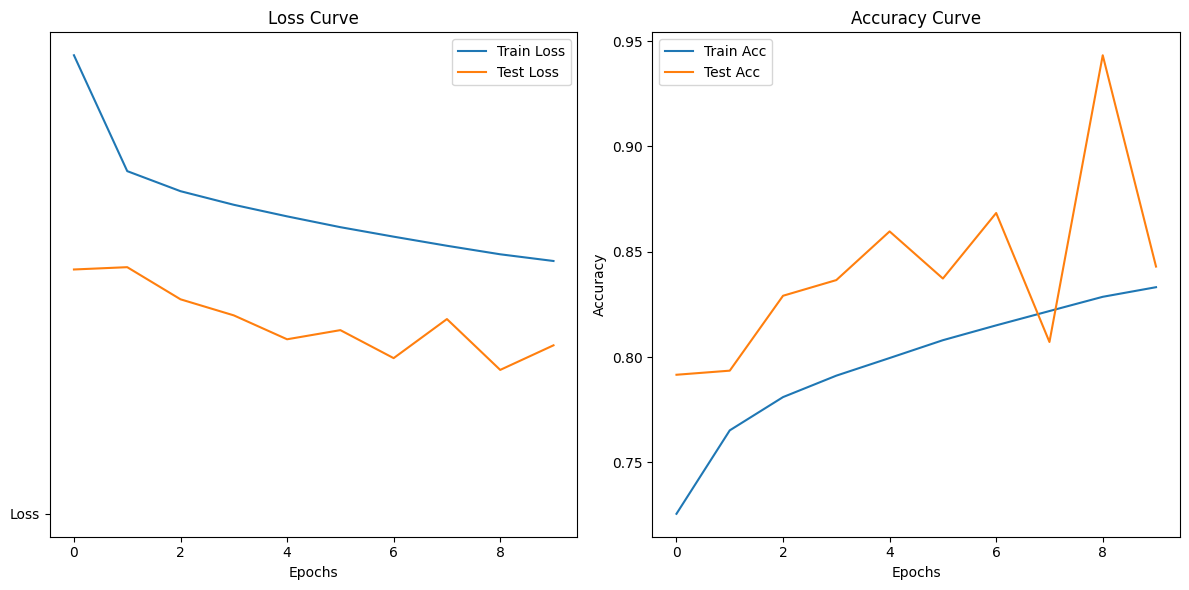

In [ ]:
model,train_losses, test_losses, train_accs, test_accs = train_nn(mlp_model,train_loader,test_loader,loss_fn,optimizer,device=device)

### **6. Prediction and Evaluation Function**

In [ ]:
# Predition and Evaluation Function
def evaluate_model(model, X_test,y_test,device):
  model.eval()
  with torch.no_grad():
    inputs = torch.FloatTensor(X_test).to(device)
    outputs = model(inputs)
    _,predicted = torch.max(outputs.data,1)
    predicted = predicted.cpu().numpy()

  # Print metrics
  print(f"\nModel Evaluation Metrics : ")
  print(f"----------------------------")
  print(f"Accuracy : {accuracy_score(y_test,predicted)}")
  print(f"Precision : {precision_score(y_test,predicted,average='weighted')}")
  print(f"Recall : {recall_score(y_test,predicted,average='weighted')}")
  print(f"F1 Score : {f1_score(y_test,predicted,average='weighted')}")

  print(f"\nDetailed Classification Report: ")
  print(classification_report(y_test,predicted))

  return predicted

### **7. Evaluation Metrics for MLP Model**

In [ ]:
predicted_labels = evaluate_model(mlp_model,X_test_scaled,y_test,device=device)


Model Evaluation Metrics : 
----------------------------
Accuracy : 0.8429936913871876
Precision : 0.9400293374855296
Recall : 0.8429936913871876
F1 Score : 0.8732552145516781

Detailed Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    454265
           1       0.00      0.00      0.00       391
           2       0.89      0.94      0.91     25605
           3       0.68      0.90      0.78      2059
           4       0.97      0.66      0.79     46025
           5       0.71      0.81      0.76      1100
           6       0.75      0.48      0.59      1159
           7       0.97      0.49      0.65      1587
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         7
          10       0.29      1.00      0.44     31761
          11       0.97      0.52      0.67      1180
          12       0.00      0.00      0.00       301
          13       0.00      0.0

### **Since our data is numeric and structured so, the traditional ML model like random forest works best for this kind of data.**

### **That's why our MLP model is not worked better for this data. The neural network model works better on the unstructured data.**